In [9]:
import pandas as pd
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle, Patch
from func import cal_buoyancy,sounding_cal
import glob
import os
import textwrap
from haversine import haversine, Unit
import re
import datetime
import metpy.calc as mpcalc
from metpy.units import units
from metpy import constants
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
# from pyhdf import SD
from scipy.interpolate import interp1d
from scipy.optimize import bisect
import numpy as np
import pickle
import numpy as np
import math
import pint
import seaborn as sns
from pydoc import help
# from pyhdf.SD import *
from sklearn.preprocessing import QuantileTransformer
import xarray as xr
import netCDF4 as nc
import re
import matplotlib.pyplot as plt
from numpy import load
from numpy import asarray
from numpy import save
import pytz
from scipy import stats
from sklearn.linear_model import LinearRegression
from collections import Counter
import pymannkendall as mk
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [10]:
# Set display options to show all rows and columns in dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [23]:
with open('soundings_fig1&4_final.pkl', 'rb') as file:
    
    df14 = pickle.load(file)

df14 = df14[['tercile','blt','Blc']]

df14.shape

(2435, 3)

In [24]:
with open('soundings_fig2&3.pdkl', 'rb') as file:
    
    df23 = pickle.load(file)

df23.shape

(2384, 27)

In [25]:
df = df14.join(df23, how='inner')

df.shape

(2198, 30)

In [26]:
with open('soundings_fig5&6.pdkl', 'wb') as file:
    
    pickle.dump(df, file)

In [15]:
custom_boundaries = [df['blt'].min(), 
                     df['blt'].quantile(1/10), 
                     df['blt'].quantile(2/10),
                     df['blt'].quantile(3/10),
                     df['blt'].quantile(4/10),
                     df['blt'].quantile(5/10),
                     df['blt'].quantile(6/10),
                     df['blt'].quantile(7/10),
                     df['blt'].quantile(8/10),
                     df['blt'].quantile(9/10),
                     df['blt'].max()]

df['blt_percentile'] = pd.cut(df['blt'], bins=custom_boundaries, labels=[.05, .15, .25, .35, .45, .55, .65, .75, .85, .95], include_lowest=True)


In [16]:
custom_boundaries = [df['Blc'].min(), 
                     df['Blc'].quantile(1/10), 
                     df['Blc'].quantile(2/10),
                     df['Blc'].quantile(3/10),
                     df['Blc'].quantile(4/10),
                     df['Blc'].quantile(5/10),
                     df['Blc'].quantile(6/10),
                     df['Blc'].quantile(7/10),
                     df['Blc'].quantile(8/10),
                     df['Blc'].quantile(9/10),
                     df['Blc'].max()]

df['blc_percentile'] = pd.cut(df['Blc'], bins=custom_boundaries, labels=[.05, .15, .25, .35, .45, .55, .65, .75, .85, .95], include_lowest=True)


In [8]:
# with open('soundings_fig5&6.pdkl', 'wb') as file:
    
#     pickle.dump(df, file)

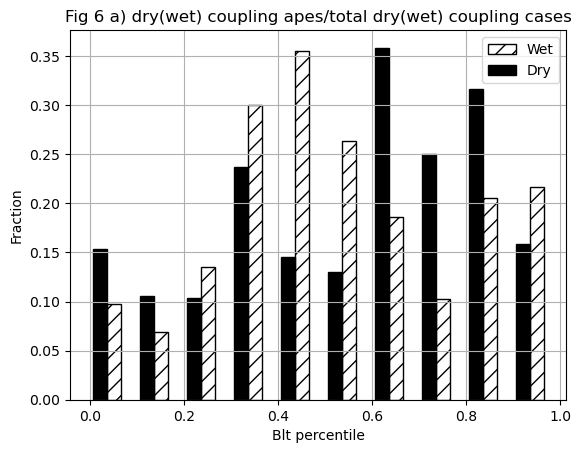

In [17]:
#figure 6a -- #wet/dry coupling APES/#total wet/dry cases

wet = df[df["wet_coupling"]==True]

wet = wet.groupby("blt_percentile").agg({'APE': 'sum', 'wet_coupling': 'sum'})

wet['ratio'] = wet['APE'] / wet['wet_coupling']

dry = df[df["dry_coupling"]==True]

dry = dry.groupby("blt_percentile").agg({'APE': 'sum', 'dry_coupling': 'sum'})

dry['ratio'] = dry['APE'] / dry['dry_coupling']

dryx_positions= np.array(dry.index)-0.03

wetx_positions = wet.index

plt.bar(wetx_positions, wet['ratio'], width=0.03, edgecolor='black', color='white', hatch='//', label='Wet')

plt.bar(dryx_positions, dry['ratio'], width=0.03, edgecolor='black', color='black', label='Dry')

plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1]) 
plt.xlabel("Blt percentile")
plt.ylabel("Fraction")
plt.title("Fig 6 a) dry(wet) coupling apes/total dry(wet) coupling cases")
plt.legend()
plt.grid()
plt.show()


-Figure 6a shows that, for the dry-coupling cases, the fractional occurrence of APEs (defined as the proportion of APEs relative to all dry-coupling cases) in each BLT bin increases with BLT up to its 70th percentile

-For the wet-coupling cases, the fractional occurrence of the APEs peaks when BLT is between the 30th and 70th percentile. Thus, APEs appear to prefer higher LT humidity under dry coupling than under wet coupling.

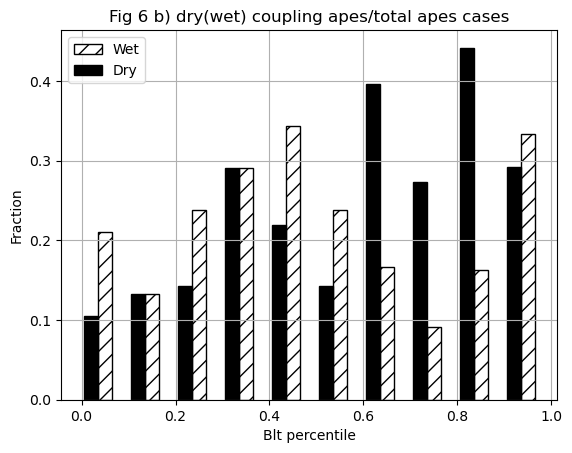

In [18]:
#figure 6b -- #wet/dry coupling APES/#total wet/dry cases

apes = df[df["APE"]==True]

wetapes = apes.groupby("blt_percentile").agg({'APE': 'sum', 'wet_coupling': 'sum'})

wetapes['ratio'] = wetapes['wet_coupling'] / wetapes['APE']

dryapes = apes.groupby("blt_percentile").agg({'APE': 'sum', 'dry_coupling': 'sum'})

dryapes['ratio'] = dryapes['dry_coupling'] / dryapes['APE']

#figure 6b -- dry(wet) coupling apes/total apes cases

# wetx_positions = np.array(dry.index)-0.03

dryx_positions= np.array(dryapes.index)-0.03

wetx_positions = wetapes.index

plt.bar(wetx_positions, wetapes['ratio'], width=0.03, edgecolor='black', color='white', hatch='//', label='Wet')
plt.bar(dryx_positions, dryapes['ratio'], width=0.03, edgecolor='black', color='black', label='Dry')

plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1]) 
plt.xlabel("Blt percentile")
plt.ylabel("Fraction")
plt.title("Fig 6 b) dry(wet) coupling apes/total apes cases")
plt.legend()
plt.grid()
plt.show()


-Next, we explore how BLT affects the partition of dry-coupling versus wet-coupling APEs. Figure 6b shows that the proportion of the dry-coupling APEs relative to all APEs increases with BLT, with a strong correlation (R = 0.89, p<0.05). The proportion ranges from 0.04 at the bottom 10% to 0.47 at the top 10% of BLT. However, the proportion of wet-coupling APEs per BLT bin peaks at lower to medium BLT percentiles (30%-50%) and decreases almost monotonically with increasing BLT from 50% to 100%.

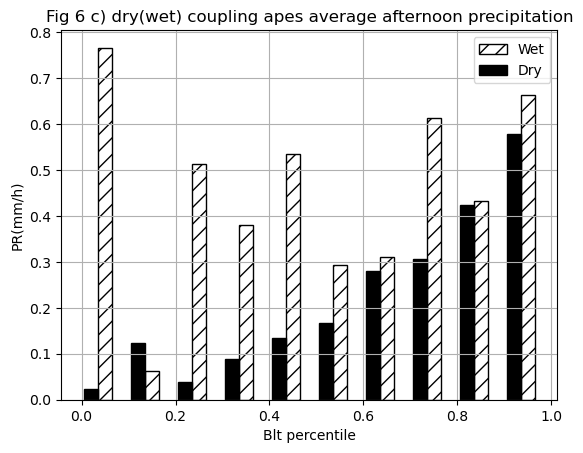

In [19]:
#figure 6c -- #wet/dry coupling APES/#total wet/dry cases

wet_apes = df[(df["wet_coupling"]==True) & (df["APE"]==True)]

wet_apes_p = pd.DataFrame(wet_apes.groupby("blt_percentile")['afternoon'].mean())

wet_apes_p['afternoon'] = (wet_apes_p['afternoon'])/7

dry_apes = df[(df["dry_coupling"]==True) & (df["APE"]==True)]

dry_apes_p = pd.DataFrame(dry_apes.groupby("blt_percentile")['afternoon'].mean())

dry_apes_p['afternoon'] = (dry_apes_p['afternoon'])/7

dryx_positions= np.array(dry_apes_p.index)-0.03

wetx_positions = wet_apes_p.index

plt.bar(wetx_positions, wet_apes_p['afternoon'], width=0.03, edgecolor='black', color='white', hatch='//', label='Wet')

plt.bar(dryx_positions, dry_apes_p['afternoon'], width=0.03, edgecolor='black', color='black', label='Dry')

plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1]) 

plt.xlabel("Blt percentile")

plt.ylabel("PR(mm/h)")

plt.title("Fig 6 c) dry(wet) coupling apes average afternoon precipitation")

plt.legend()

plt.grid()

plt.show()


We also investigate how BLT affects rain rates associated with dry-coupling and wet-coupling APEs, respectively.Figure 6c shows a clear increase in rain rate with BLT for the dry-coupling APEs, except for the 90-100th percentile of BLT, where there are few APEs samples. In contrast, we find no clear dependence of rain rate on BLT for the wet coupling APEs. Thus, our findings suggest that a high BLT tends to increase the frequency and intensity of the dry coupling APEs, as well as the relative frequency of dry-coupling APEs compared to wet-coupling APEs.

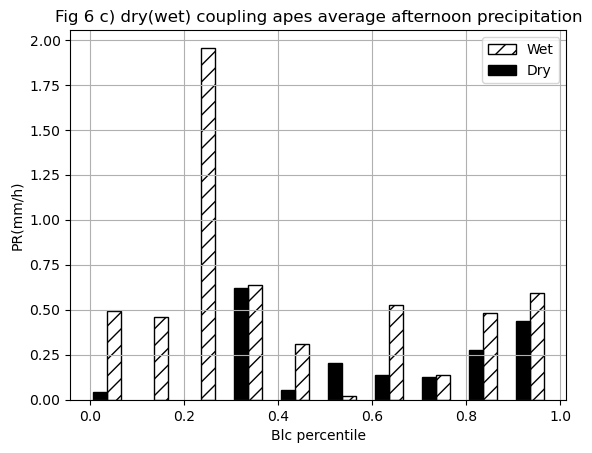

In [20]:
#figure 6c -- #wet/dry coupling APES/#total wet/dry cases

wet_apes_p = pd.DataFrame(wet_apes.groupby("blc_percentile")['afternoon'].mean())

wet_apes_p['afternoon'] = (wet_apes_p['afternoon'])/7

dry_apes_p = pd.DataFrame(dry_apes.groupby("blc_percentile")['afternoon'].mean())

dry_apes_p['afternoon'] = (dry_apes_p['afternoon'])/7

dryx_positions= np.array(dry_apes_p.index)-0.03

wetx_positions = wet_apes_p.index

plt.bar(wetx_positions, wet_apes_p['afternoon'], width=0.03, edgecolor='black', color='white', hatch='//', label='Wet')

plt.bar(dryx_positions, dry_apes_p['afternoon'], width=0.03, edgecolor='black', color='black', label='Dry')

plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1]) 
plt.xlabel("Blc percentile")
plt.ylabel("PR(mm/h)")
plt.title("Fig 6 c) dry(wet) coupling apes average afternoon precipitation")
plt.legend()
plt.grid()
plt.show()


In [21]:
all_apes = df[df['APE'] & (df['dry_coupling'] | df['wet_coupling'])]

all_apes.shape

(154, 32)

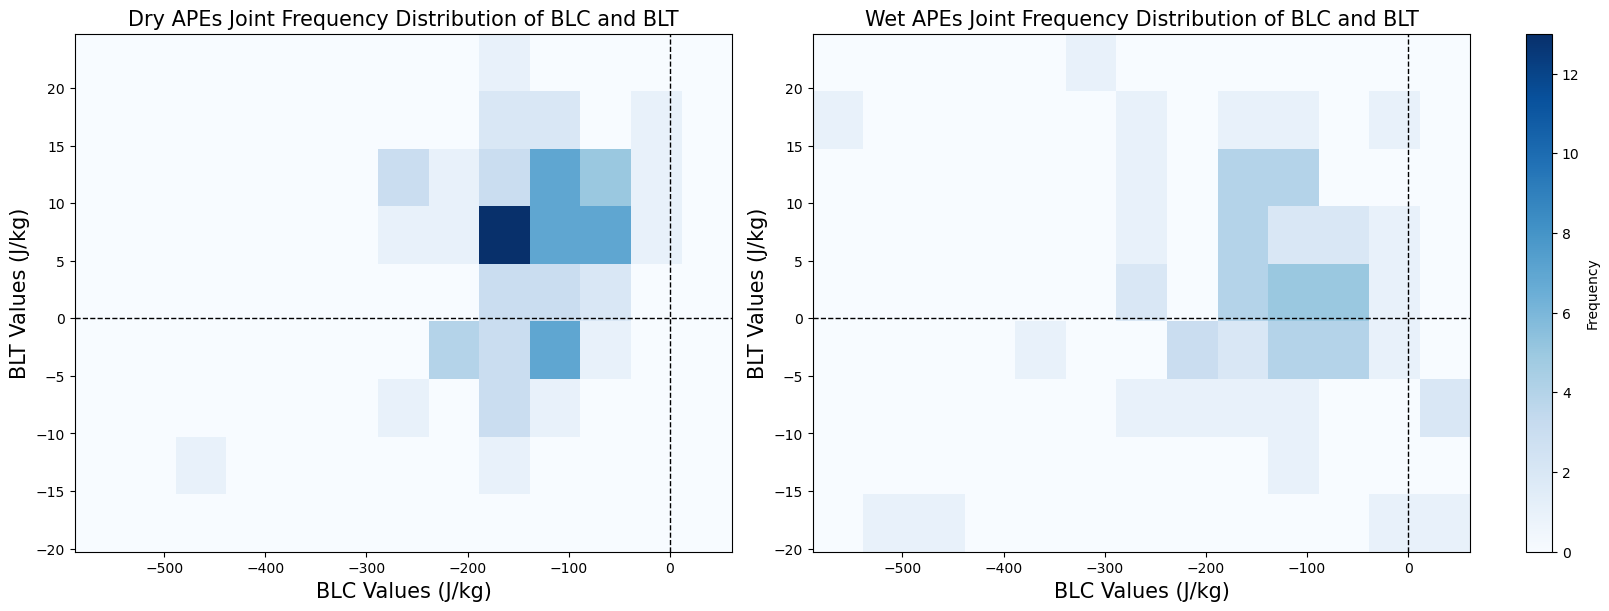

In [22]:
# Assuming you have already filtered the all_apes DataFrame
blc_bins = np.arange(all_apes['Blc'].min(), all_apes['Blc'].max() + 50, 50)  # Bins every 50 units

blt_bins = np.arange(all_apes['blt'].min(), all_apes['blt'].max() + 5, 5)    # Bins every 5 units

apedfs = {'Dry APEs': dry_apes,
          'Wet APEs': wet_apes}

# Calculate histograms to find the maximum value for normalization
histograms = {}
max_value = 0

for title, df in apedfs.items():
    hist, xedges, yedges = np.histogram2d(df['Blc'], df['blt'], bins=[blc_bins, blt_bins])
    histograms[title] = (hist, xedges, yedges)
    max_value = max(max_value, hist.max())  # Find the maximum histogram value

# Create a figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

# Plot each histogram on its own subplot
for ax, (title, (hist, xedges, yedges)) in zip(axes, histograms.items()):
    X, Y = np.meshgrid(xedges, yedges)
    c = ax.pcolormesh(X, Y, hist.T, cmap='Blues', shading='auto', vmin=0, vmax=max_value)
    
    # Adding zero lines for reference
    ax.axhline(0, color='black', linewidth=1, linestyle='--')
    ax.axvline(0, color='black', linewidth=1, linestyle='--')
    
    # Set axis labels and title
    ax.set_xlabel('BLC Values (J/kg)',fontsize=15)
    ax.set_ylabel('BLT Values (J/kg)', fontsize=15)
    ax.set_title(f'{title} Joint Frequency Distribution of BLC and BLT', fontsize=15)

# Add a color bar to the right of the plots that spans both subplots
fig.colorbar(c, ax=axes, label='Frequency', orientation='vertical', fraction=0.02, pad=0.04)

# Show the plot
plt.show()


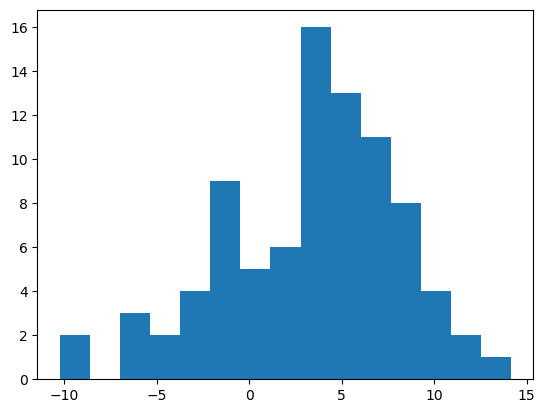

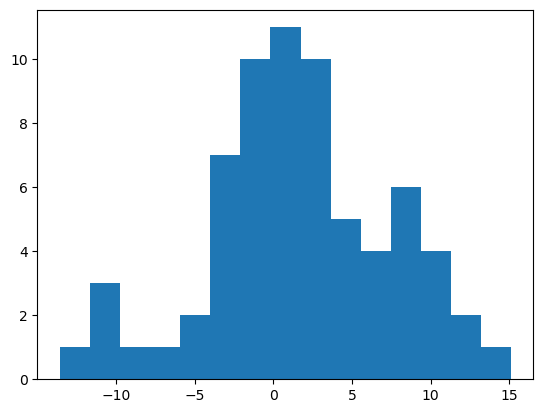

In [15]:
plt.hist(dry_apes['blt'],bins=15)
plt.show()

plt.hist(wet_apes['blt'],bins=15)
plt.show()


## joint freq distribution for each BMU

In [31]:
with open('bmu_for_fig56.pdkl', 'rb') as file:
    
    bmu_for_fig56 = pickle.load(file)

bmu_for_fig56.shape

(91,)

In [32]:
bmujf = pd.merge(bmu_for_fig56, dry_apes, left_index=True, right_index=True, how='inner')

bmujf.shape

(86, 33)

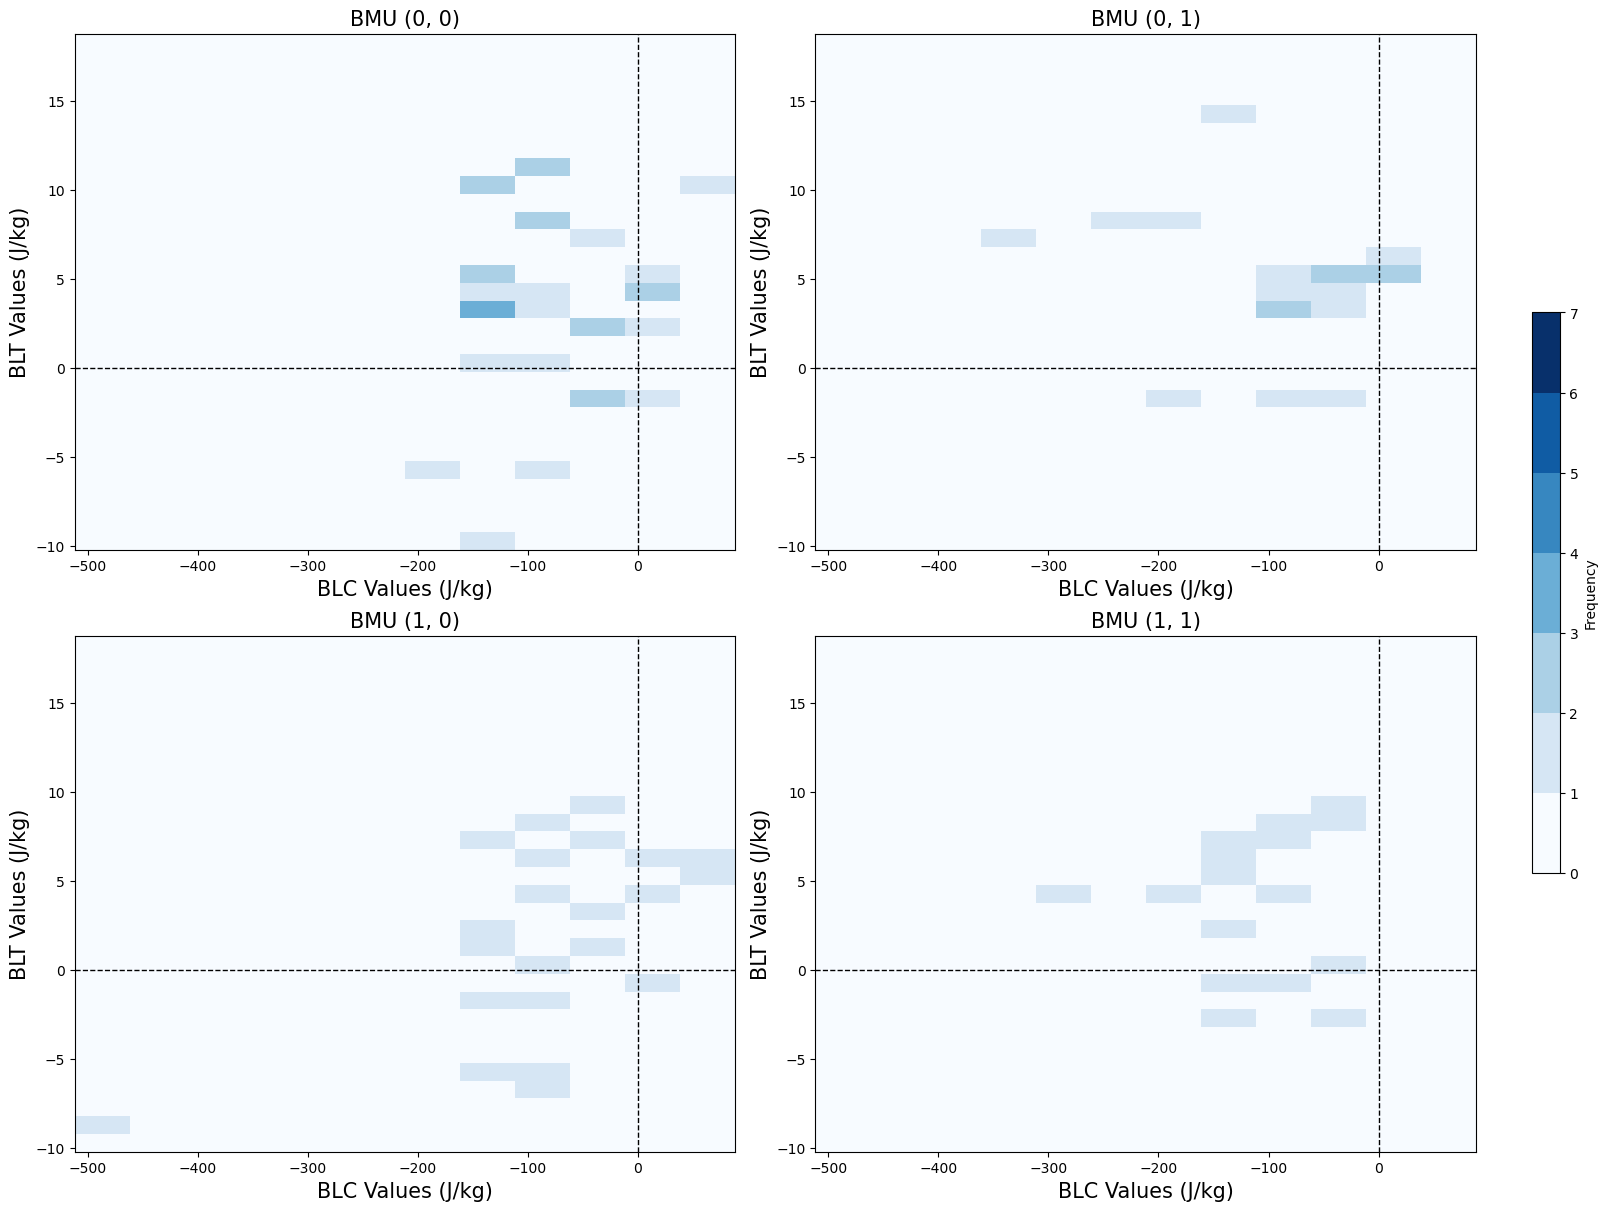

In [33]:
# Define your BMUs and filter your DataFrame
all_bmus = np.unique(bmujf['bmu'])

# Initialize variables to store global axis limits and color bar range
global_blc_min = np.inf
global_blc_max = -np.inf
global_blt_min = np.inf
global_blt_max = -np.inf
global_max_hist = 0

# First pass to find global axis limits and color bar range
for i in all_bmus:
    filtered_df = bmujf[bmujf['bmu'] == i]
    
    # Update global axis limits
    global_blc_min = min(global_blc_min, filtered_df['Blc'].min())
    global_blc_max = max(global_blc_max, filtered_df['Blc'].max())
    global_blt_min = min(global_blt_min, filtered_df['blt'].min())
    global_blt_max = max(global_blt_max, filtered_df['blt'].max())
    
    # Define the bins for Blc and blt
    blc_bins = np.arange(global_blc_min, global_blc_max + 50, 50)
    blt_bins = np.arange(global_blt_min, global_blt_max + 5, 1)
    
    # Calculate histograms for the filtered DataFrame
    hist, _, _ = np.histogram2d(filtered_df['Blc'], filtered_df['blt'], bins=[blc_bins, blt_bins])
    global_max_hist = 7  # Update global max histogram value

# Define discrete colors based on histogram counts
num_colors = 7  # Number of discrete colors
discrete_cmap = plt.get_cmap('Blues', num_colors)
norm = mcolors.BoundaryNorm(boundaries=np.linspace(0, global_max_hist, num_colors + 1), ncolors=num_colors)

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12), constrained_layout=True)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each histogram on its own subplot
for ax, i in zip(axes, all_bmus):
    filtered_df = bmujf[bmujf['bmu'] == i]
    
    # Define the bins for Blc and blt
    blc_bins = np.arange(global_blc_min, global_blc_max + 50, 50)
    blt_bins = np.arange(global_blt_min, global_blt_max + 5, 1)
    
    # Calculate histograms for the filtered DataFrame
    hist, xedges, yedges = np.histogram2d(filtered_df['Blc'], filtered_df['blt'], bins=[blc_bins, blt_bins])
    
    # Plot the histogram with discrete colors
    X, Y = np.meshgrid(xedges, yedges)
    c = ax.pcolormesh(X, Y, hist.T, cmap=discrete_cmap, norm=norm, shading='auto')
    
    # Adding zero lines for reference
    ax.axhline(0, color='black', linewidth=1, linestyle='--')
    ax.axvline(0, color='black', linewidth=1, linestyle='--')

    # Set axis labels and title
    ax.set_xlabel('BLC Values (J/kg)', fontsize=15)
    ax.set_ylabel('BLT Values (J/kg)', fontsize=15)
    ax.set_title(f'BMU {i}', fontsize=15)

# Add a color bar to the right of the plots
fig.colorbar(c, ax=axes, label='Frequency', orientation='vertical', fraction=0.02, pad=0.04)

# Show the plot
plt.show()


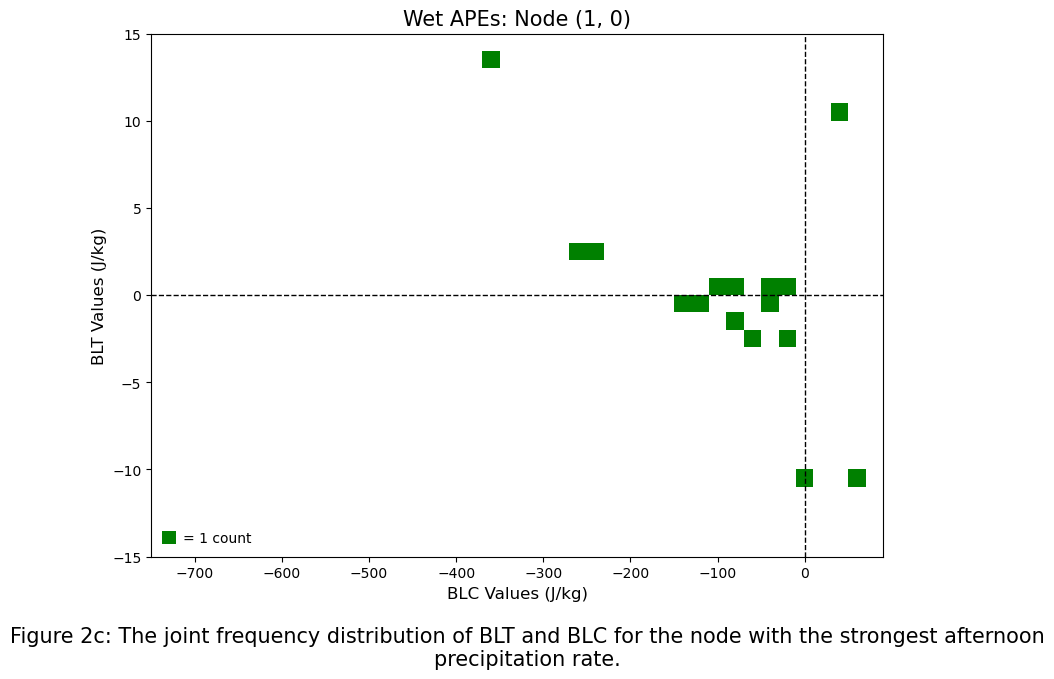

In [30]:
# Sample DataFrame and filtering
bmu_node = (1, 0)  # Replace with your specific BMU value

filtered_df = bmujf[bmujf['bmu'] == bmu_node]

# Define the bins for Blc and blt
blc_bins = np.arange(-750, 100 + 10, 20)  # Bins every 50 units
blt_bins = np.arange(-15, 16, 1)  # Bins every 5 units

# Calculate the histogram
hist, xedges, yedges = np.histogram2d(filtered_df['Blc'], filtered_df['blt'], bins=[blc_bins, blt_bins])

# Create a binary colormap with full opacity dark green
binary_cmap = mcolors.ListedColormap([(1, 1, 1), (0, 0.5, 0)])  # Dark green with no transparency

# Normalize the color map to switch between white (zero count) and dark green (non-zero count)
norm = mcolors.BoundaryNorm(boundaries=[0, 1, hist.max()], ncolors=2)

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

# Plot the histogram
X, Y = np.meshgrid(xedges, yedges)
c = ax.pcolormesh(X, Y, hist.T, cmap=binary_cmap, norm=norm, shading='auto')

# Adding zero lines for reference
ax.axhline(0, color='black', linewidth=1, linestyle='--')
ax.axvline(0, color='black', linewidth=1, linestyle='--')

# Set axis labels and title
ax.set_xlabel('BLC Values (J/kg)', fontsize=12)
ax.set_ylabel('BLT Values (J/kg)', fontsize=12)
ax.set_title(f'Wet APEs: Node {bmu_node}', fontsize=15)

# Create a Patch to match the size and color of the histogram squares
legend_patch = Patch(facecolor=(0, 0.5, 0), edgecolor='none')  # Dark green color

# Add the legend to the plot
ax.legend([legend_patch], ['= 1 count'], loc='lower left', fontsize=10, frameon=False,
          handlelength=1, handleheight=1, handletextpad=0.5, borderpad=0.3)

# Add text annotations
# ax.text(0.5, 14, 'Moist LT', fontsize=12, color='black', ha='center')
# ax.text(-375, 14, 'Dry LT', fontsize=12, color='black', ha='center')
# ax.text(-700, -10, 'dry bl', fontsize=12, color='black', ha='center')
# ax.text(50, -10, 'Warm', fontsize=12, color='black', ha='center')

caption = "Figure 2c: The joint frequency distribution of BLT and BLC for the node with the strongest afternoon precipitation rate."

wrapped_caption = "\n".join(textwrap.wrap(caption, width=100))

plt.figtext(0.55, -0.1, wrapped_caption, ha='center', fontsize=15)

# Show the plot
plt.show()
